Imports

In [85]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from keras import layers
from keras import Sequential

import pathlib

Parameters

In [86]:
img_height, img_width = 300, 300
batch_size = 32

# Load images from directory and split into training and validation sets
data_dir = pathlib.Path("../data")
all_data = []

Collecting Data from the data Folder

In [87]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

810


Split the Data into Training and Validation Sets

In [88]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 810 files belonging to 54 classes.
Using 648 files for training.
Found 810 files belonging to 54 classes.
Using 162 files for validation.


Visualising Data

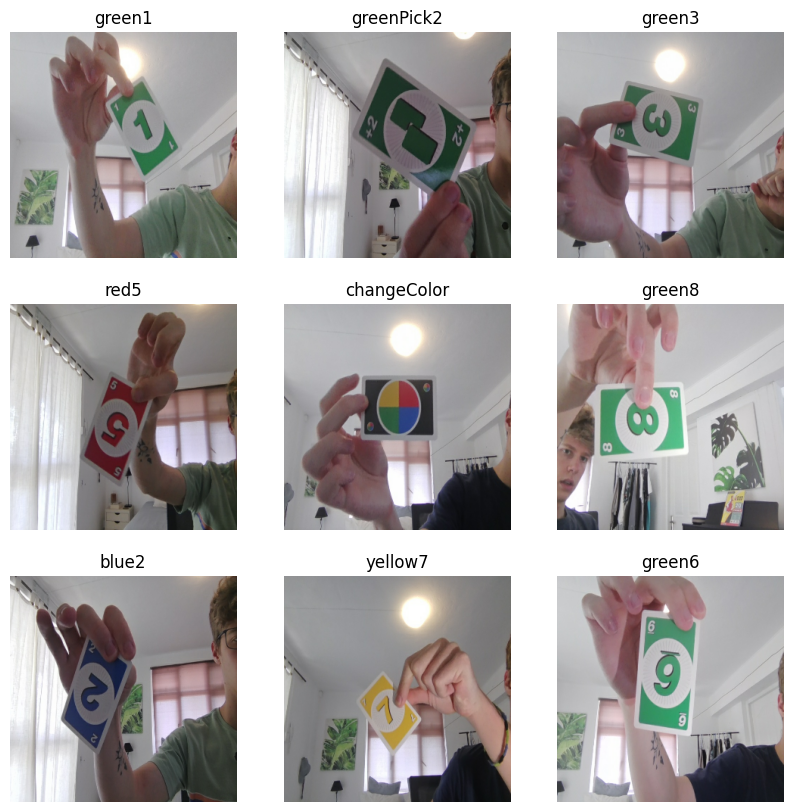

In [89]:
class_names = train_ds.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Configure the Dataset for Performance

In [90]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Standardizing the Data

In [91]:
normalization_layer = layers.Rescaling(1./255)

Augmenting the Data
(Generates additional training data from the existing examples by augmenting them using random transformations that yield believable-looking images)

In [92]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

Creating the Model

Note that this Model has three convolustion blocks (tf.keras.layers.Conv2D) and a max pooling layer (tf.keras.layers.MaxPooling2D) in each of them. There's a fully-connected layer (tf.keras.layers.Dense) with 128 units on top of it that is activated by a ReLU activation function ('relu'). Dropout is included to prevent overfitting of the model.

In [93]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

Compiling the Model

In [94]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Model Summary (Viewing all the layers of the Network)

In [95]:
model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_11 (Sequential)      │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_13 (Rescaling)        │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 300, 300, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 150, 150, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 150, 150, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 87616)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │    11,214,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ (None, 54)             │         6,966 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,245,526 (42.90 MB)

 Trainable params: 11,245,526 (42.90 MB)

 Non-trainable params: 0 (0.00 B)

Training the Model (training for 15 epochs)

In [96]:
epochs = 15

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 180ms/step - accuracy: 0.0192 - loss: 4.2930 - val_accuracy: 0.0247 - val_loss: 3.9873
Epoch 2/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 171ms/step - accuracy: 0.0348 - loss: 3.9837 - val_accuracy: 0.0309 - val_loss: 3.9805
Epoch 3/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 169ms/step - accuracy: 0.0630 - loss: 3.9373 - val_accuracy: 0.0556 - val_loss: 3.7873
Epoch 4/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 161ms/step - accuracy: 0.0805 - loss: 3.6639 - val_accuracy: 0.0926 - val_loss: 3.5262
Epoch 5/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 161ms/step - accuracy: 0.1735 - loss: 3.0671 - val_accuracy: 0.1235 - val_loss: 3.3278
Epoch 6/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - accuracy: 0.2809 - loss: 2.4623 - val_accuracy: 0.2160 - val_loss: 2.6128
Epoch 7/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step - accuracy: 0.2950 - loss: 2.2946 - val_accuracy: 0.2346 - val_loss: 2.2982
Epoch 8/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - accuracy: 0.4330 - loss: 1.7801 - val_accuracy: 0.

Visualizing Training Results

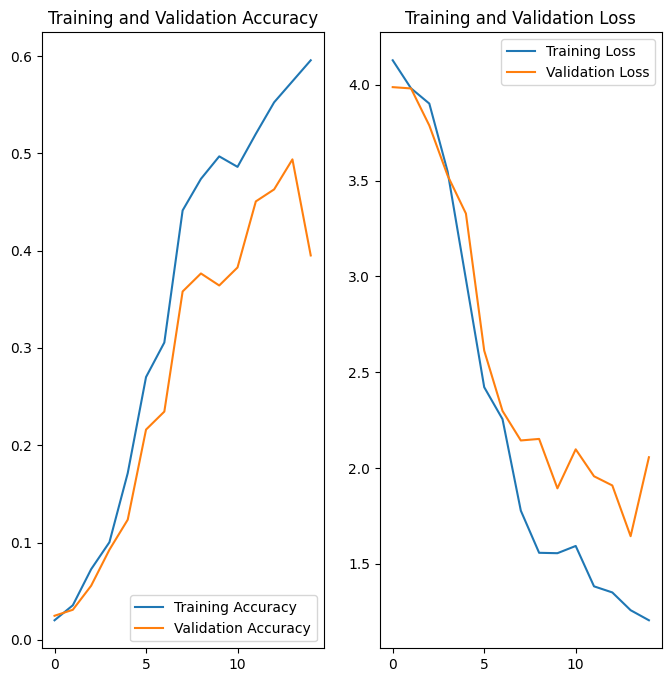

In [97]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Predicting on New Data

In [99]:
card_path = '../testing_data/red6.jpg'

img = tf.keras.utils.load_img(
    card_path, target_size=(img_height, img_width)
)

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
This image most likely belongs to red3 with a 45.51 percent confidence.
